In [2]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     - -------------------------------------- 0.1/3.0 MB 1.3 MB/s eta 0:00:03
     -- ------------------------------------- 0.2/3.0 MB 1.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.2/3.0 MB 1.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.2/3.0 MB 1.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.2/3.0 MB 1.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.2/3.0 MB 1.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.2/3.0 MB 1.6 MB/s eta 0:00:02
     --- ------------------------------------ 0.2/3.0 MB 573.4 kB/s eta 0:00:05
     --- ------------------------------------ 0.2/3.0 MB 573.4 kB/s eta 0:00:05
     --- ------------------------------------ 0.2/3.0 MB 573.4 kB/s eta 0:00:05
     --- ------------------------------------ 0.2/3.0 MB 573.4 kB/s eta 

In [3]:
import yfinance as yf

In [4]:
sp500=yf.Ticker('^GSPC')

In [5]:
sp500=sp500.history(period='max')

In [18]:
sp500.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-08-20 00:00:00-04:00,5602.879883,5620.509766,5585.500000,5597.120117,2994420000,0.0,0.0
2024-08-21 00:00:00-04:00,5603.089844,5632.680176,5591.569824,5620.850098,3119670000,0.0,0.0
2024-08-22 00:00:00-04:00,5637.770020,5643.220215,5560.950195,5570.640137,2981530000,0.0,0.0
2024-08-23 00:00:00-04:00,5602.490234,5641.819824,5585.160156,5634.609863,3291940000,0.0,0.0
2024-08-26 00:00:00-04:00,5639.660156,5651.620117,5608.439941,5623.620117,848140904,0.0,0.0


In [19]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-08-13 00:00:00-04:00', '2024-08-14 00:00:00-04:00',
               '2024-08-15 00:00:00-04:00', '2024-08-16 00:00:00-04:00',
               '2024-08-19 00:00:00-04:00', '2024-08-20 00:00:00-04:00',
               '2024-08-21 00:00:00-04:00', '2024-08-22 00:00:00-04:00',
               '2024-08-23 00:00:00-04:00', '2024-08-26 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24279, freq=None)

<Axes: xlabel='Date'>

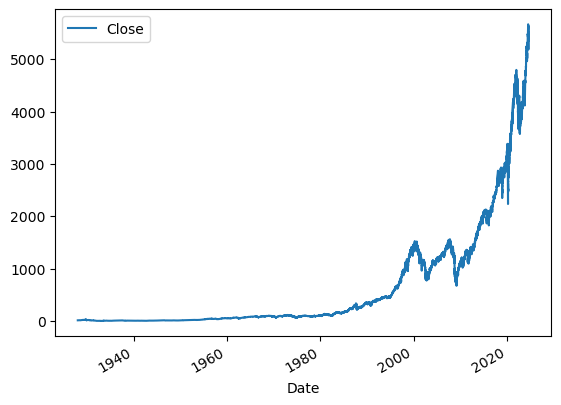

In [39]:
sp500.iloc[:].plot(y='Close',use_index=True)

In [37]:
sp500=sp500.drop(columns=['Dividends','Stock Splits'])

In [60]:
sp500['Tomorrow']=sp500['Close'].shift(-1)

In [62]:
sp500['Target']=(sp500['Tomorrow'] > sp500['Close']).astype(int)

In [64]:
sp500=sp500.loc['1990-01-01':].copy()

In [68]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=500,min_samples_split=100,random_state=1)

train=sp500.iloc[:-100]
test=sp500.iloc[-100:]

predictors=['Close','Volume','Open','High','Low']
model.fit(train[predictors],train['Target'])


RandomForestClassifier(min_samples_split=100, n_estimators=500, random_state=1)

In [69]:
from sklearn.metrics import precision_score

preds=model.predict(test[predictors])

In [72]:
import pandas as pd

preds=pd.Series(preds,index=test.index)
precision_score(test['Target'],preds)

0.5

<Axes: xlabel='Date'>

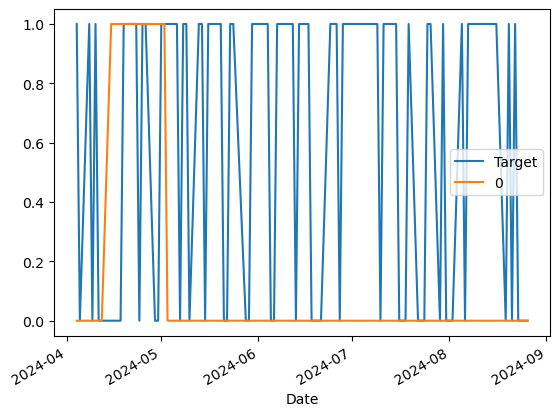

In [73]:
combined=pd.concat([test['Target'],preds],axis=1)
combined.plot()

In [74]:
def predict(train,test,predictors,model):
	model.fit(train[predictors],train['Target'])
	preds=model.predict(test[predictors])
	preds=pd.Series(preds,index=test.index,name='Predictions')
	combined=pd.concat([test['Target'],preds],axis=1)
	return combined

In [75]:
def backtest(data,model,predictors,start=2500,step=250):
	all_predictions=[]
	for i in range(start,data.shape[0],step):
		train=data.iloc[0:i].copy()
		test=data.iloc[i:(i+step)].copy()
		predictions=predict(train,test,predictors,model)
		all_predictions.append(predictions)
	return pd.concat(all_predictions)

In [76]:
predictions=backtest(sp500,model,predictors)

In [77]:
predictions['Predictions'].value_counts()

Predictions
0    3639
1    2590
Name: count, dtype: int64

In [78]:
precision_score(predictions['Target'],predictions['Predictions'])

0.5285714285714286

In [79]:
predictions['Target'].value_counts() / predictions.shape[0]

Target
1    0.535559
0    0.464441
Name: count, dtype: float64

In [84]:
horizons=[2,5,60,250,1000]
new_predictors=[]

for horizon in horizons:
	rolling_averages=sp500.rolling(horizon).mean()
	
	ratio_column=f'Close_Ratio_{horizon}'
	sp500[ratio_column]=sp500['Close'] / rolling_averages['Close']
	
	Trend_column=f'Trend_{horizon}'
	sp500[Trend_column]=sp500.shift(1).rolling(horizon).sum()['Target']
	
	new_predictors+=[ratio_column,Trend_column]


In [91]:
sp500=sp500.dropna()

In [93]:
sp500.shape

(7728, 17)